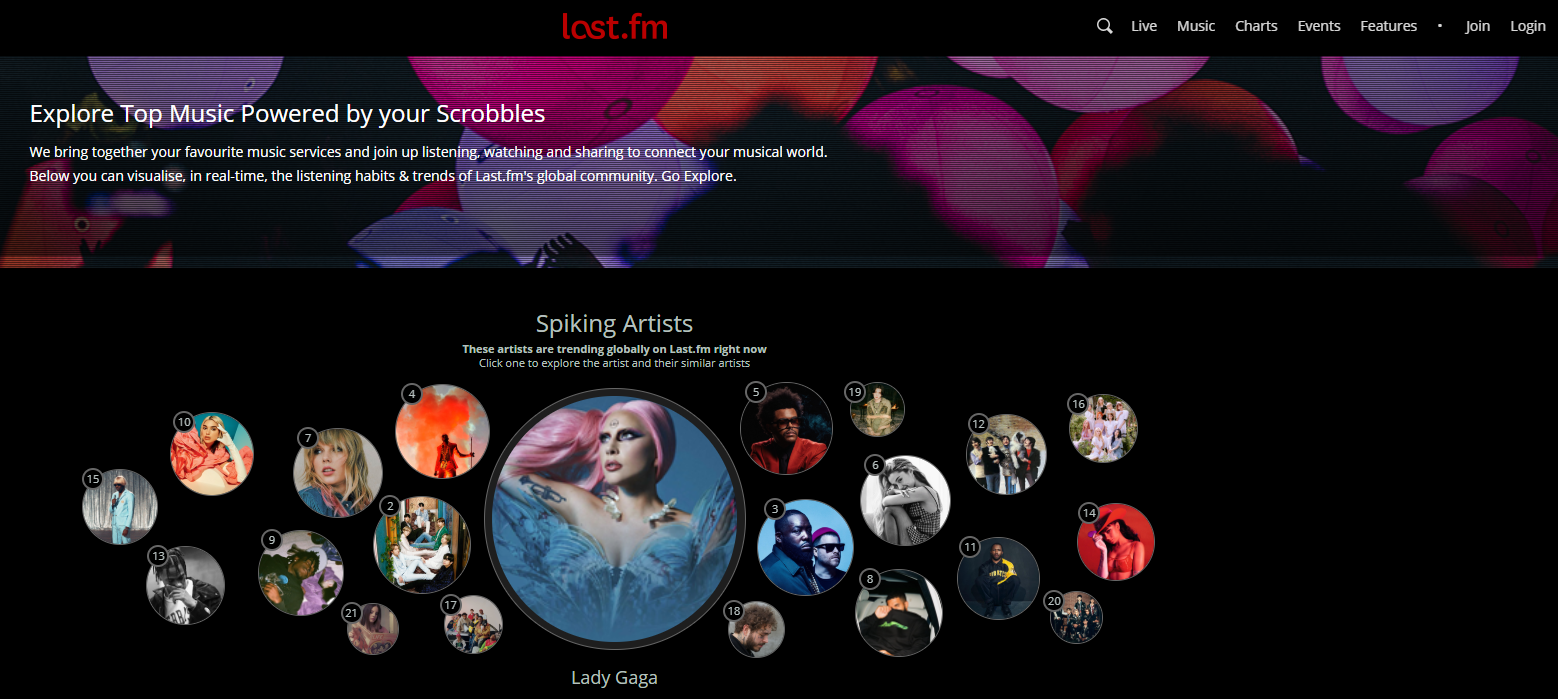

## Sistema de Recomendação: Last.fm

Data Set: https://www.upf.edu/web/mtg/lastfm360k
crédito: https://github.com/beckernick/music_recommender

## Temos 2 arquivos - os dados com as interações (plays) dos usuários em relação aos artistas e as informações dos usuários x país. 

In [ ]:
import pandas as pd
from scipy.spatial.distance import cosine
import numpy as np
from scipy.sparse import csr_matrix

# apresentar números com 3 casas decimais
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
user_data = pd.read_table(r'c:/data/usersha1-artmbid-artname-plays_1.tsv',
                          header = None, nrows = 2e7,
                          names = ['users', 'musicbrainz-artist-id', 'artist-name', 'plays'],
                          usecols = ['users', 'artist-name', 'plays'])

In [ ]:
user_profiles = pd.read_table(r'c:/data/usersha1-profile.tsv',
                          header = None,
                          names = ['users', 'gender', 'age', 'country', 'signup'],
                          usecols = ['users', 'country'])

## Exploração dos Datasets

In [ ]:
user_data.head()

In [ ]:
user_profiles.head()

## Totalização da quantidade de plays por artista

In [ ]:
# remove registros em que não há o nome do artista
#if user_data['artist-name'].isnull().sum() > 0:
#    user_data = user_data.dropna(axis = 0, subset = ['artist-name'])

In [ ]:
artist_plays = (user_data.
     groupby(by = ['artist-name'])['plays'].
     sum().
     reset_index().
     rename(columns = {'plays': 'total_artist_plays'})
     [['artist-name', 'total_artist_plays']]
    )

In [ ]:
artist_plays.head()

## Merge dos dados de usuários com o total de cada artista

In [ ]:
user_data_with_artist_plays = user_data.merge(artist_plays, left_on = 'artist-name', right_on = 'artist-name', how = 'left')

In [ ]:
user_data_with_artist_plays.head()

## Vamos verificar as informações de plays por artista

Provavelmente a grande maioria de artistas não tem muitas execuções

In [ ]:
print(artist_plays['total_artist_plays'].describe())

In [ ]:
print(artist_plays['total_artist_plays'].quantile(np.arange(.9, 1, .01)))

## <font color=red> Definição de uma quantidade mínima de plays por artista </font>

In [ ]:
popularity_threshold = 50000
user_data_popular_artists = user_data_with_artist_plays.query('total_artist_plays >= @popularity_threshold')
user_data_popular_artists.head()

## Vamos selecionar somente os dados dos Estados Unidos

In [ ]:
combined = user_data_popular_artists.merge(user_profiles, left_on = 'users', right_on = 'users', how = 'left')

In [ ]:
# vamos verificar 
pd.options.display.max_rows = 999
combined['country'].value_counts()
#combined['country'].value_counts(normalize=True)

In [ ]:
usa_data = combined.query('country == \'United States\'')
usa_data.head()

## Remoção de duplicados

In [ ]:
if not usa_data[usa_data.duplicated(['users', 'artist-name'])].empty:
    initial_rows = usa_data.shape[0]
    
    print('Initial dataframe shape {0}'.format(usa_data.shape))
    usa_data = usa_data.drop_duplicates(['users', 'artist-name'])
    current_rows = usa_data.shape[0]
    print('New dataframe shape {0}'.format(usa_data.shape))
    print('Removed {0} rows'.format(initial_rows - current_rows))


## Utilizadndo KNN para fazer recomendações
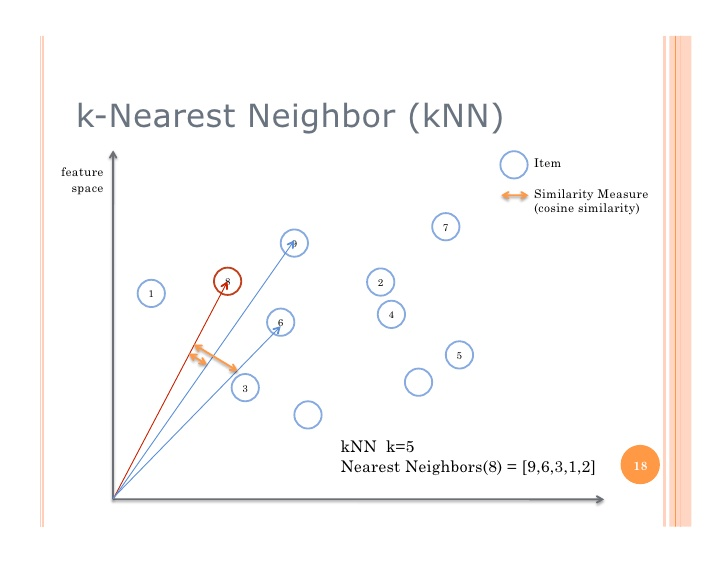

## Formatação (shape) dos Dados

Para o K-Nearest Neighbors, vamos formatar o`(artist, user)` em um array, em que cada linha é um artista e cada coluna é um usuário. Vamos utilizar o 'pivot' do pandas e incluir '0' nos dados faltantes já que serão executadas operações de álgebra linear (cosine distance) nos dados. Também vamos passar os dados para uma matriz esparsa para que a execução seja mais eficiente.

In [ ]:
wide_artist_data = usa_data.pivot(index = 'artist-name', columns = 'users', values = 'plays').fillna(0)
wide_artist_data.head(20)

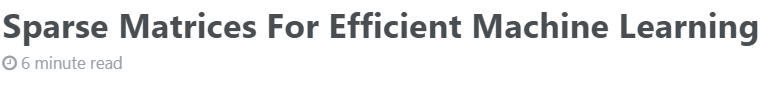
https://dziganto.github.io/Sparse-Matrices-For-Efficient-Machine-Learning/

In [ ]:
# utilização do 'Compressed Sparse Row matrix'
from scipy.sparse import csr_matrix
wide_artist_data_sparse = csr_matrix(wide_artist_data.values)

In [ ]:
# funções para salvar e carregar a matriz
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

save_sparse_csr('lastfm_sparse_artist_matrix.npz', wide_artist_data_sparse)

## Fit do Modelo

In [ ]:
from sklearn.neighbors import NearestNeighbors
# vamos utilizar cosine distance como nossa métrica
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(wide_artist_data_sparse)

## Recomendação através de um artista selecionado aleatoriamente

In [ ]:
# geração do número aleatório
query_index = np.random.choice(wide_artist_data.shape[0])
print(query_index)

# vamos passar os dados para um array, no formato que o modelo espera
vetor = np.array(wide_artist_data.iloc[query_index, :]).reshape(1, -1)

# captura das informações melhores vizinhos com o modelo treinado
distances, indices = model_knn.kneighbors(vetor, n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(wide_artist_data.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, wide_artist_data.index[indices.flatten()[i]], distances.flatten()[i]))

## Vamos utilizar 'Fuzzy Matching' para facilitar nossa busca pelo nome
pip install fuzzywuzzy

In [ ]:
import string
from fuzzywuzzy import fuzz

In [ ]:
def print_artist_recommendations(query_artist, artist_plays_matrix, knn_model, k):
    """
    Inputs:
    query_artist: nome do artista o qual queremos recomendações
    artist_plays_matrix: dataframe com o play count dataframe (o do pandas dataframe, não a matriz esparsa)
    knn_model: modelo que treinamos
    k: quantidade de vizinhos
    """
    # inicialização de variáveis
    query_index = None
    ratio_tuples = []
    
    
    for i in artist_plays_matrix.index:
        # faz a busca 'fuzzy' - adiciona se for parecido com a query que foi informada na entrada da função
        ratio = fuzz.ratio(i.lower(), query_artist.lower())
        if ratio >= 75:
            current_query_index = artist_plays_matrix.index.tolist().index(i)
            ratio_tuples.append((i, ratio, current_query_index))
   
    # apresenta resultados
    print('Possible matches: {0}\n'.format([(x[0], x[1]) for x in ratio_tuples]))
    
    # captura o índice do artista teve o melhor match 
    try:
        query_index = max(ratio_tuples, key = lambda x: x[1])[2] # get the index of the best artist match in the data
    except:
        print('Your artist didn\'t match any artists in the data. Try again')
        return None
    
    # formatação da entrada do modelo e chamada
    vetor = np.array(artist_plays_matrix.iloc[query_index, :])
    distances, indices = knn_model.kneighbors(vetor.reshape(1, -1), n_neighbors = k)

    # apresenta os artistas selecionados 
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recommendations for {0}:\n'.format(artist_plays_matrix.index[query_index]))
        else:
            print('{0}: {1}, with distance of {2}:'.format(i, artist_plays_matrix.index[indices.flatten()[i]], distances.flatten()[i]))

    return None

## Teste com alguns artistas e bandas conhecidas

In [ ]:
print_artist_recommendations('the beatles', wide_artist_data, model_knn, k = 10)

In [ ]:
print_artist_recommendations('led zeppelin', wide_artist_data, model_knn, k = 10)

In [ ]:
print_artist_recommendations('lady gaga', wide_artist_data, model_knn, k = 10)

In [ ]:
print_artist_recommendations('sepultura', wide_artist_data, model_knn, k = 10)

In [ ]:
print_artist_recommendations('u2', wide_artist_data, model_knn, k = 10)

In [ ]:
print_artist_recommendations('beyoncé', wide_artist_data, model_knn, k = 10)